In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import load_position_dataframe


full_df = pd.read_csv('../LinearMobility_results.csv')

def build_position_dataframe(model_, seed_, angle_, speed_, nodes_, broadcast_times, log_position_time, window_threshold_time, sim_time):
    path = f'../{model_}/seed{seed_}_time{time}_angle{angle_}_speed{speed_}'
    common_columns = ['timestamp', 'frequency', 'sim_time', 'broadcast_time', 'log_position_time']
    this_df = pd.DataFrame()
    for bt in broadcast_times:
        partial_df = load_position_dataframe(nodes_[0], bt, log_position_time, window_threshold_time, sim_time, path)
        for node in nodes_:
            if node!=nodes_[0]:
                df = load_position_dataframe(node, bt, log_position_time, window_threshold_time, sim_time, path)
                partial_df = partial_df.merge(df, how='outer', left_on=common_columns, right_on=common_columns).fillna(0)
            # partial_df = pd.concat([partial_df, df], axis=1)
        partial_df['seed'] = seed_
        partial_df['time'] = sim_time
        partial_df['angle'] = angle_
        partial_df['speed'] = speed_
        this_df = pd.concat([this_df, partial_df])
    return this_df

In [118]:
time = 60
seed = 20
speeds = [0.5, 1, 2, 4]
angles = [15, 30, 60, 90]
bts = list(np.arange(1, 20.5, 0.5)) #seconds
model = 'LinearMobility'
lp = 0.1 #seconds
wt = 5 #seconds
nodes = [1, 2]

full_position_df = pd.DataFrame()
for speed in speeds:
    for angle in angles:
        position_df = build_position_dataframe(model, seed, angle, speed, nodes, bts, lp, wt, time)
        full_position_df = pd.concat([full_position_df, position_df])


In [119]:
full_position_df['distance'] = (np.sqrt(np.power(full_position_df.x_pos_1-full_position_df.x_pos_2, 2)+np.power(full_position_df.y_pos_1-full_position_df.y_pos_2, 2)))<2.0
adj_check = (full_position_df.distance != full_position_df.distance.shift()).cumsum()
time_df = full_position_df.groupby(['node_1','distance', 'speed', 'angle', 'broadcast_time', 'frequency', 'seed', adj_check], as_index=False, sort=False)['distance'].sum()
real_contact_time = time_df.groupby(['node_1', 'speed', 'angle', 'broadcast_time', 'frequency', 'seed'], as_index=False, sort=False).sum()
real_contact_time['distance'] = real_contact_time['distance']*0.1

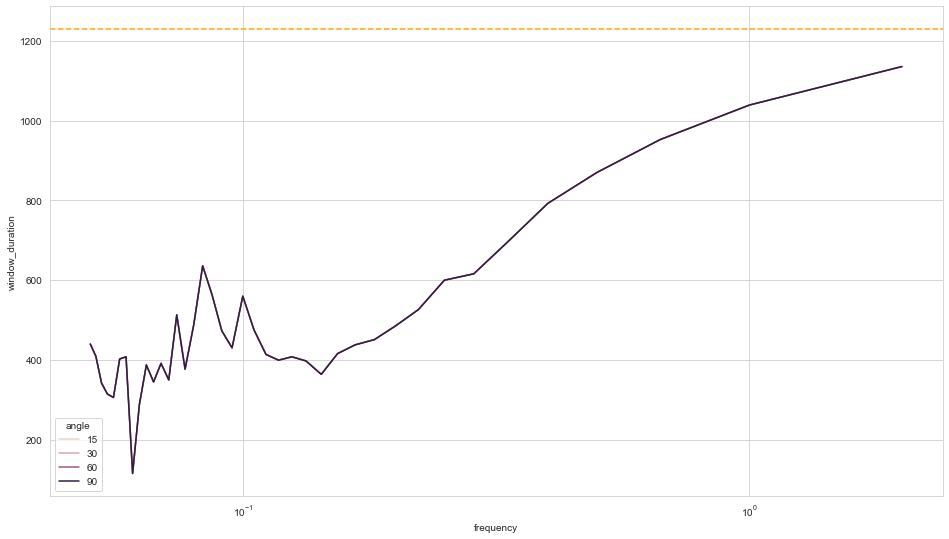

In [120]:
time = 60
seed = 20
speed = 0.5
angles = [15, 30, 60, 90]

angles_df = full_df[(full_df['time']==time) & (full_df['seed']==seed) & (full_df['speed']==speed) & (full_df['angle'].isin(angles))]
angles_pos_df = real_contact_time[(real_contact_time['seed']==seed) & (real_contact_time['speed']==speed) & (real_contact_time['angle'].isin(angles))]
angles_df = angles_df.drop(["told_by", "hop", "start", "end", "sim_time"], axis=1).groupby(["node", "seen_id", "broadcast_time", "frequency", "angle", "seed", "speed", "time"], as_index=False).sum()


a4_dims = (16,9)
fig, ax = plt.subplots(figsize=a4_dims)
plot = sns.lineplot(data=angles_df[['frequency', 'angle', 'window_duration']], x="frequency", y="window_duration", hue='angle', ax=ax)
ax.axhline(y=angles_pos_df['distance'].mean(), color = 'orange', linestyle = '--')
plot.set(xscale='log')
plt.show()

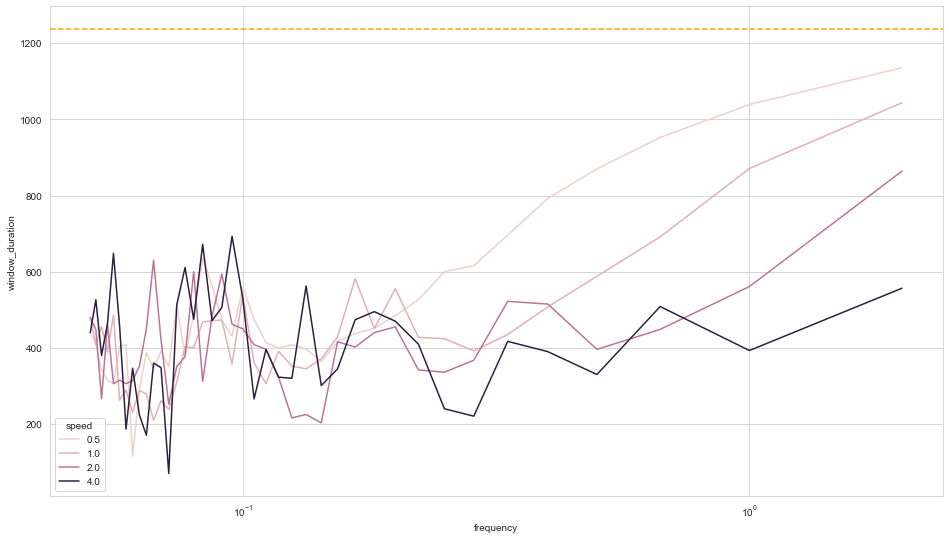

In [121]:
time = 60
seed = 20
speeds = [0.5, 1, 2, 4]
angle = 30

speeds_df = full_df[(full_df['time']==time) & (full_df['seed']==seed) & (full_df['speed'].isin(speeds)) & (full_df['angle']==angle)]
speeds_pos_df = real_contact_time[(real_contact_time['seed']==seed) & (real_contact_time['speed'].isin(speeds)) & (real_contact_time['angle']==angle)]
speeds_df = speeds_df.drop(["told_by", "hop", "start", "end", "sim_time"], axis=1).groupby(["node", "seen_id", "broadcast_time", "frequency", "angle", "seed", "speed", "time"], as_index=False).sum()

a4_dims = (16,9)
fig, ax = plt.subplots(figsize=a4_dims)
plot = sns.lineplot(data=speeds_df[['frequency', 'speed', 'window_duration']], x="frequency", y="window_duration", hue='speed', ax=ax)
ax.axhline(y=speeds_pos_df['distance'].mean(), color = 'orange', linestyle = '--')
plot.set(xscale='log')
plt.show()

In [122]:
"""
porcentaje del tiempo de contacto respecto al tiempo de simulacion
por ejemplo:
    1h de simulacion - 50% de contacto
    2h de simulacion - 45% de contacto

justificar las opciones a la hora de proponer un protocolo

por ahi otro punto seria determinar cuanto influye la frecuencia en la deteccion del contacto sin darle tanta importancia al tiempo de los contactos.
"""
time = 60
speeds = [0.5, 1, 2, 4]
angles = [30]
# bts = list(np.arange(1, 20.5, 0.5))
window_count = full_position_df.groupby(['node_1','distance', 'speed', 'angle', 'broadcast_time', 'frequency', 'seed', adj_check], as_index=False, sort=False)['distance'].sum()
window_count_df = pd.DataFrame()
for speed in speeds:
    for angle in angles:
        for bt in bts:
            window_real = np.count_nonzero(window_count[(window_count['angle']==angle) & (window_count['speed']==speed) & (window_count['broadcast_time']==bt)].distance!=0)
            contact_time = speeds_pos_df[(speeds_pos_df['angle']==angle) & (speeds_pos_df['speed']==speed) & (speeds_pos_df['broadcast_time']==bt)]['distance'].iloc[0]
            window_estimated = full_df[(full_df['angle']==angle) & (full_df['speed']==speed) & (full_df['broadcast_time']==bt) & (full_df['time']==time)].shape[0]
            data = [{'angle':angle, 'speed':speed, 'broadcast_time':bt, 'windows_real':window_real, 'windows_estimated':window_estimated, 'contact_time':contact_time}]
            df = pd.DataFrame(data, index=np.arange(len(data)))
            window_count_df = pd.concat([window_count_df, df])

# window_count_df[window_count_df['broadcast_time']==bt]
window_count_df

,angle,speed,broadcast_time,windows_real,windows_estimated,contact_time
0,30,0.5,1.0,195,610,1230.3
0,30,0.5,1.5,195,602,1230.3
0,30,0.5,2.0,195,588,1230.3
0,30,0.5,2.5,195,581,1230.3
0,30,0.5,3.0,195,580,1230.3
...,...,...,...,...,...,...
0,30,4.0,18.0,1573,135,1237.5
0,30,4.0,18.5,1573,132,1237.5
0,30,4.0,19.0,1573,125,1237.5
0,30,4.0,19.5,1573,123,1237.5


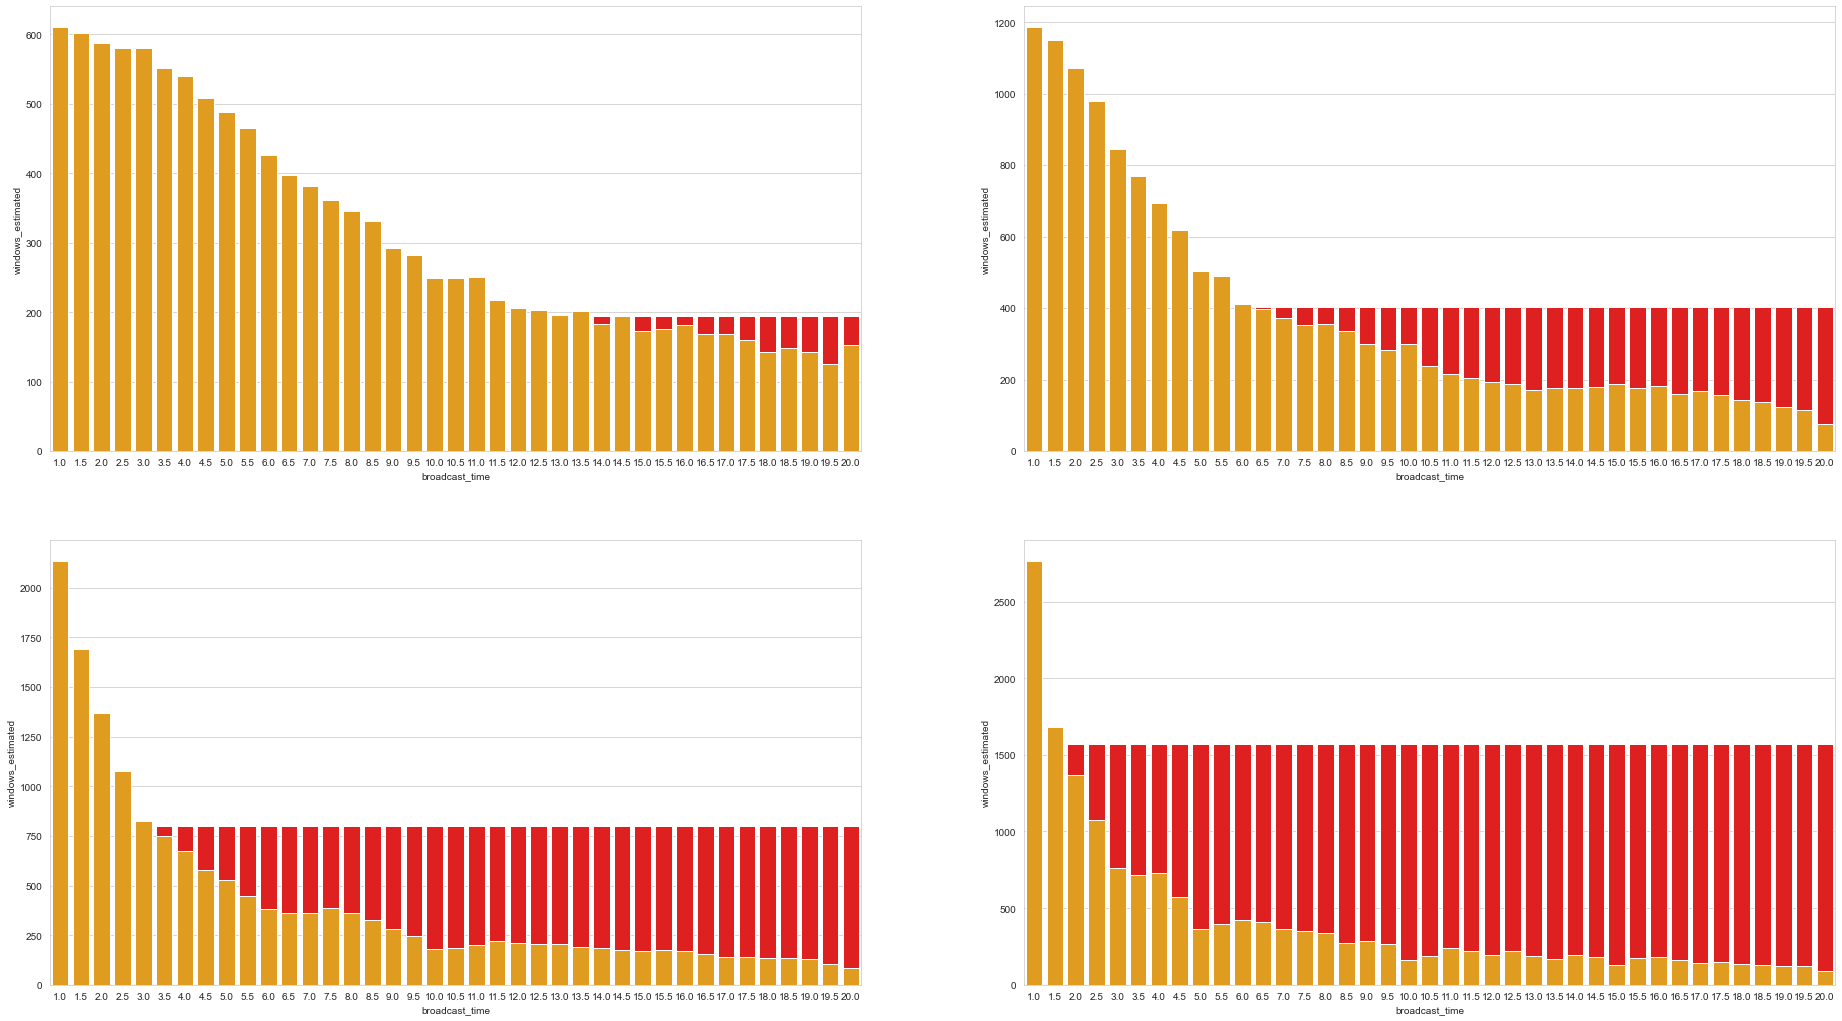

In [123]:
dims = (32,18)
fig, ax = plt.subplots(2,2,figsize=dims)
speed_reshape = np.array(speeds).reshape(2,2)
for i in range(speed_reshape.shape[0]):
    for j in range(speed_reshape.shape[1]):
        sns.barplot(data=window_count_df[window_count_df['speed']==speed_reshape[i,j]], x='broadcast_time', y='windows_real', ax=ax[i,j], color='red')
        sns.barplot(data=window_count_df[window_count_df['speed']==speed_reshape[i,j]], x='broadcast_time', y='windows_estimated', ax=ax[i,j], color='orange')

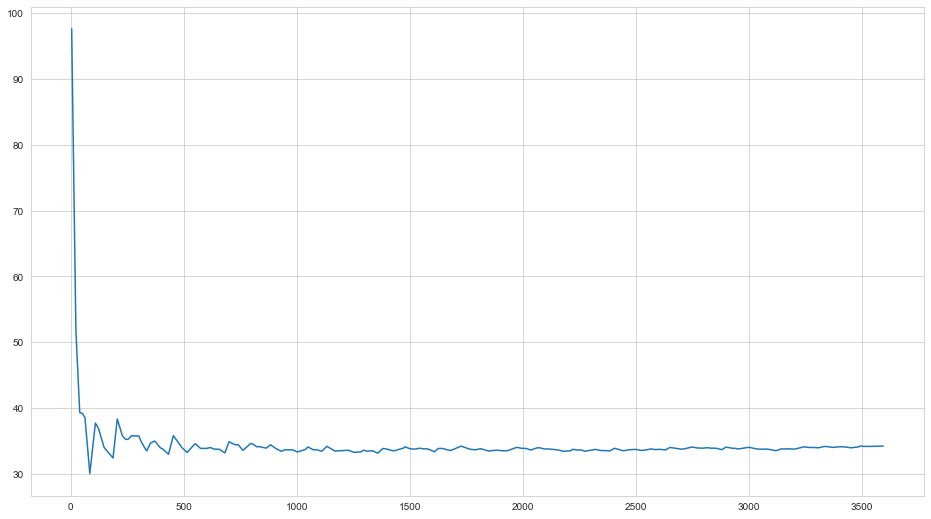

In [127]:
angle = 30
speed = 0.5
broadcast_time = 1
stabilization_df = full_position_df[(full_position_df['angle']==angle) & (full_position_df['speed']==speed) & (full_position_df['broadcast_time']==bt)]
# stabilization_df
adj_check_stabilization = (stabilization_df.distance != stabilization_df.distance.shift()).cumsum()
timestamp_vs_contact = stabilization_df.groupby(['node_1','distance', 'speed', 'angle', 'broadcast_time', 'frequency', 'seed', 'timestamp', 'distance', adj_check_stabilization], as_index=False, sort=False)['distance'].sum()[['timestamp', 'distance']]
# time_dff.groupby(['timestamp', 'node_1', 'speed', 'angle', 'broadcast_time', 'frequency', 'seed'], as_index=False, sort=False).sum()
timestamp = timestamp_vs_contact['timestamp'].to_numpy()
contact = timestamp_vs_contact['distance'].to_numpy()

contact_it = np.nditer(contact, flags=['f_index'])

count_contact = []
timestamp_cumsum_contact = []
for x in contact_it:
    if contact_it.index == 0:
        count = 0
        prev_value = 1
        # timestamp_cumsum_contact.append(0)
    else:
        prev_value = contact[contact_it.index - 1]
    if prev_value==1 and x==1:
        count += 1
    elif prev_value==1 and x==0:
        count_contact.append(count)
        timestamp_cumsum_contact.append(timestamp[contact_it.index])
        count=1

contact_count_it = np.nditer(np.array(count_contact), flags=['f_index'])
cumsum_contact = []

for x in contact_count_it:
    # if contact_count_it.index==0:
    #     cumsum_contact.append(0)
    cumsum_contact.append(np.array(count_contact)[0:contact_count_it.index+1].sum())


cumsum_contact = np.array(cumsum_contact)
timestamp_cumsum_contact = np.array(timestamp_cumsum_contact)
percentage = cumsum_contact*0.1/timestamp_cumsum_contact*100

dims = (16,9)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(x=timestamp_cumsum_contact, y=percentage, ax=ax)
plt.show()